In [7]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from utils.misc import *


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logical constriant

len_j = 3 # number of tasks (p の数)
len_h = 2 # number of logical constraints considered (cardinality of KB)

len_l = 4
len_u = 6
len_s = 10

len_jl = 0 # number of pointwise constraints to be counted later


len_l_list = [] # L_j の要素数のリスト
len_s_list = [] # S_j の要素数のリスト
S = [] # data for consistency constraints 

for i in range(len_j):
    if len_h != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    len_l_list.append(len(L[i]))
    len_jl += len(L[i])
    len_s_list.append(len(S_i))

S = np.stack(S)


c1 = 2.5 # degree of satisfaction for pointwise slacks
c2 = 2.5 # degree of satisfaction for logical slacks

c1 = 100
c2 = 100


w_j = cp.Variable(shape=(len_j, 3))
xi_j_l = cp.Variable(shape=(len_j, len_l), nonneg=True)
xi_h = cp.Variable(shape=(len_h * 2, 1), nonneg=True)



# 目的関数
function = 0

for j in range(len_j):
    w = w_j[j]
    function += 1/2 * (cp.norm2(w) ** 2)

for j in range(len_j):
    for l in range(len_l):
        xi = xi_j_l[j, l]
        function += c1 * xi

for h in range(len_h):
    xi = xi_h[h, 0]
    function += c2 * xi

objective_function = cp.Minimize(function)



# 制約
constraints = []

class Predicate:
    def __init__(self, w):
        self.w1 = w[0]
        self.w2 = w[1]
        self.b = w[2]

    # def func(self, x):
    #     x1, x2 = x[0], x[1]
    #     return self.w1 * x1 + self.w2 * x2 + self.b
    
    def __call__(self, x):
        x1, x2 = x[0], x[1]
        return self.w1 * x1 + self.w2 * x2 + self.b

# def predicate(x, w):
#     x1, x2 = x[0], x[1]
#     w1, w2, b = w[0], w[1], w[2]

#     return w1 * x1 + w2 * x2 + b


# pointwise
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w)
    # p = predicate

    for l in range(len_l):
        x = L[j][l, :2]
        y = L[j][l, 2]

        xi = xi_j_l[j, l]

        constraints += [
            y * (2 * p(x) - 1) >= 1 - 2 * xi
            # y * (2 * p(x, w) - 1) >= 1 - 2 * xi
        ]


# logical
for h in range(len_h):
    w_1 = w_j[h]
    w_2 = w_j[h + 1]

    p_j = Predicate(w_1)
    p_k = Predicate(w_2)
    # p = predicate

    xi_1 = xi_h[2 * h, 0]
    xi_2 = xi_h[2 * h + 1, 0]

    for u in range(len_u):
        x = U[u]

        constraints += [
            0 <= xi_1,
            p_j(x) - p_k(x) <= xi_2,
            # p(x, w_1) - p(x, w_2) <= xi,
        ]

# # logical
# for u in range(len_u):
#     x = U[u]

#     for h in range(len_h):
#         w_1 = w_j[h]
#         w_2 = w_j[h + 1]

#         p_j = Predicate(w_1).func
#         p_k = Predicate(w_2).func

#         xi = xi_h[h, 0]

#         constraints += [
#             p_j(x) - p_k(x) <= xi
#         ]




# consistency
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w)
    # p = predicate

    for s in range(len_s):
        x = S[j][s]

        constraints += [
            p(x) >= 0,
            p(x) <= 1,
            # p(x, w) >= 0,
            # p(x, w) <= 1,
        ]


problem = cp.Problem(objective_function, constraints)
result = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 15 11:34:06 AM: Your problem has 25 variables, 96 constraints, and 0 parameters.
(CVXPY) Oct 15 11:34:06 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 15 11:34:06 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 15 11:34:06 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 15 11:34:07 AM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 15 11:34:07 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Oct 15 11:34:07 AM: Applying reduction Dcp2Cone
(CVXPY) Oct 15 11:34:07 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 15 11:34:07 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 15 11:34:07 AM: Applying reduction ECOS
(CVXPY) Oct 15 11:34:07 AM: Finished problem compilation (took 3.452e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 15 11:34:07 AM: Inv

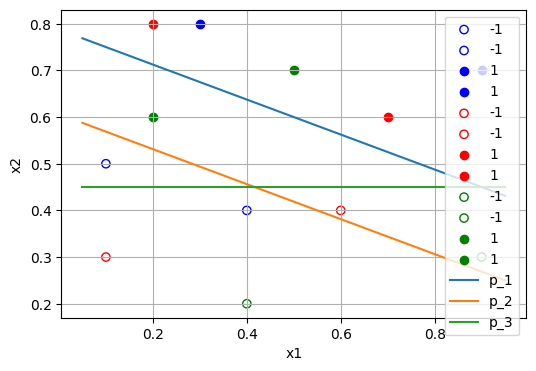

In [9]:
coeff_0 = w_j.value[0]
coeff_1 = w_j.value[1]
coeff_2 = w_j.value[2]
coeffs = [coeff_0, coeff_1, coeff_2]


def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()